<a href="https://colab.research.google.com/github/zilioalberto/N3_PO/blob/main/N3_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##N3 -Pesquisa Operacional
##Professor Jaison
##Alunos:
#Alberto Zilio
#Roni Pereira


In [6]:
## Passo 01 - Bibliotecas do Projeto

# ---------------------------------------------
# Manipulação e análise de dados
# ---------------------------------------------
import pandas as pd   # Manipulação de dados em formato de tabela (DataFrames)
import numpy as np    # Operações numéricas, vetores, matrizes e números aleatórios

# Ajustes de visualização de DataFrames no notebook

pd.set_option("display.max_columns", 50)   # Máximo de colunas exibidas
pd.set_option("display.width", 120)        # Largura máxima da saída no console/notebook


# ---------------------------------------------
# Gráficos e visualização
# ---------------------------------------------

import matplotlib.pyplot as plt  # Biblioteca base para gráficos
import seaborn as sns            # Camada de alto nível para gráficos estatísticos

# Configurações gerais de gráficos

# Garante que os gráficos apareçam dentro do notebook
%matplotlib inline
sns.set_theme(style="whitegrid") # Define estilo visual padrão dos gráficos
plt.rcParams["figure.figsize"] = (10, 6)  # Tamanho padrão das figuras (largura x altura)


# ---------------------------------------------
# Estatística / distribuições (para Monte Carlo)
# ---------------------------------------------
from scipy import stats          # Funções estatísticas e distribuições de probabilidade


# ---------------------------------------------
# Utilitários diversos
# ---------------------------------------------
from pathlib import Path         # Facilita o trabalho com caminhos de arquivos e diretórios


# ---------------------------------------------
# Reprodutibilidade dos experimentos
# ---------------------------------------------
np.random.seed(42)               # Fixa a semente aleatória para reproduzir os resultados


In [9]:
## Passo 02 - Carregando os datasets a partir do GitHub

## Local de coleta do dataset:
# https://mavenanalytics.io/data-playground/pizza-place-sales

# ---------------------------------------------
# URL base do repositório no GitHub (modo "raw")
# ---------------------------------------------
base_url = "https://raw.githubusercontent.com/zilioalberto/N3_PO/main/pizza_sales/"

# Montagem das URLs completas de cada arquivo CSV
url_orders        = base_url + "orders.csv"
url_order_details = base_url + "order_details.csv"
url_pizzas        = base_url + "pizzas.csv"
url_pizza_types   = base_url + "pizza_types.csv"

print("URL orders       :", url_orders)
print("URL order_details:", url_order_details)
print("URL pizzas       :", url_pizzas)
print("URL pizza_types  :", url_pizza_types)

# ---------------------------------------------
# Leitura dos arquivos CSV a partir das URLs
# ---------------------------------------------

# Orders: informações de data/hora e ID dos pedidos
orders = pd.read_csv(url_orders)

# Order details: quais pizzas foram vendidas em cada pedido
order_details = pd.read_csv(url_order_details)

# Pizzas: informações de preço, tamanho e tipo de pizza
pizzas = pd.read_csv(url_pizzas)

# Pizza types: descrição, categoria e ingredientes (normalmente tem acentos)
pizza_types = pd.read_csv(url_pizza_types, encoding="latin1")

# ---------------------------------------------
# Visão geral inicial dos dados
# ---------------------------------------------
print("orders:")
display(orders.head())

print("\norder_details:")
display(order_details.head())

print("\npizzas:")
display(pizzas.head())

print("\npizza_types:")
display(pizza_types.head())


URL orders       : https://raw.githubusercontent.com/zilioalberto/N3_PO/main/pizza_sales/orders.csv
URL order_details: https://raw.githubusercontent.com/zilioalberto/N3_PO/main/pizza_sales/order_details.csv
URL pizzas       : https://raw.githubusercontent.com/zilioalberto/N3_PO/main/pizza_sales/pizzas.csv
URL pizza_types  : https://raw.githubusercontent.com/zilioalberto/N3_PO/main/pizza_sales/pizza_types.csv
orders:


,order_id,date,time
0,1,2015-01-01,11:38:36
1,2,2015-01-01,11:57:40
2,3,2015-01-01,12:12:28
3,4,2015-01-01,12:16:31
4,5,2015-01-01,12:21:30



order_details:


,order_details_id,order_id,pizza_id,quantity
0,1,1,hawaiian_m,1
1,2,2,classic_dlx_m,1
2,3,2,five_cheese_l,1
3,4,2,ital_supr_l,1
4,5,2,mexicana_m,1



pizzas:


,pizza_id,pizza_type_id,size,price
0,bbq_ckn_s,bbq_ckn,S,12.75
1,bbq_ckn_m,bbq_ckn,M,16.75
2,bbq_ckn_l,bbq_ckn,L,20.75
3,cali_ckn_s,cali_ckn,S,12.75
4,cali_ckn_m,cali_ckn,M,16.75



pizza_types:


,pizza_type_id,name,category,ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
2,ckn_alfredo,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
3,ckn_pesto,The Chicken Pesto Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Spinach, Garli..."
4,southw_ckn,The Southwest Chicken Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja..."


In [10]:
## Passo 03 - Preparação, junção e exportação do dataset unificado

# ---------------------------------------------
# 3.1 - Verificando estrutura básica de cada tabela
# ---------------------------------------------
print("orders:")
display(orders.head())
print(orders.info())

print("\norder_details:")
display(order_details.head())
print(order_details.info())

print("\npizzas:")
display(pizzas.head())
print(pizzas.info())

print("\npizza_types:")
display(pizza_types.head())
print(pizza_types.info())


# ---------------------------------------------
# 3.2 - Conversão de tipos básicos (datas, etc.)
# ---------------------------------------------

# Converter coluna de data para tipo datetime
orders["date"] = pd.to_datetime(orders["date"])

# A coluna "time" podemos manter como string por enquanto
# (vamos usar se quisermos análise por horário)


# ---------------------------------------------
# 3.3 - Junção das tabelas em um único DataFrame
# ---------------------------------------------
# order_details + orders (trazendo data e hora do pedido)
df = order_details.merge(
    orders[["order_id", "date", "time"]],  # seleciona apenas colunas relevantes
    on="order_id",
    how="left"
)

# Junta com a tabela de pizzas (preço, tamanho, tipo)
df = df.merge(
    pizzas,                   # 'pizza_id', 'pizza_type_id', 'size', 'price'
    on="pizza_id",
    how="left"
)

# Junta com pizza_types (nome, categoria, ingredientes)
df = df.merge(
    pizza_types,              # 'pizza_type_id', 'name', 'category', 'ingredients'
    on="pizza_type_id",
    how="left"
)


# ---------------------------------------------
# 3.4 - Criando coluna de faturamento por linha
# ---------------------------------------------
# Receita de cada linha = preço da pizza * quantidade vendida na linha
df["revenue"] = df["price"] * df["quantity"]


# ---------------------------------------------
# 3.5 - Inspeção rápida do DataFrame final
# ---------------------------------------------
print("DataFrame unificado (df):")
display(df.head())

print("\nInformações gerais do df:")
print(df.info())

print("\nVerificando valores nulos por coluna:")
print(df.isna().sum())


# ---------------------------------------------
# 3.6 - Exportando o dataset unificado para CSV
# ---------------------------------------------
# Caminho do arquivo a ser salvo no ambiente do Colab
output_path = "pizza_sales_unificado.csv"

# Exporta o DataFrame sem o índice numérico
df.to_csv(output_path, index=False)

print(f"\nArquivo exportado com sucesso para: {output_path}")


orders:


,order_id,date,time
0,1,2015-01-01,11:38:36
1,2,2015-01-01,11:57:40
2,3,2015-01-01,12:12:28
3,4,2015-01-01,12:16:31
4,5,2015-01-01,12:21:30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21350 entries, 0 to 21349
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  21350 non-null  int64 
 1   date      21350 non-null  object
 2   time      21350 non-null  object
dtypes: int64(1), object(2)
memory usage: 500.5+ KB
None

order_details:


,order_details_id,order_id,pizza_id,quantity
0,1,1,hawaiian_m,1
1,2,2,classic_dlx_m,1
2,3,2,five_cheese_l,1
3,4,2,ital_supr_l,1
4,5,2,mexicana_m,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   order_details_id  48620 non-null  int64 
 1   order_id          48620 non-null  int64 
 2   pizza_id          48620 non-null  object
 3   quantity          48620 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

pizzas:


,pizza_id,pizza_type_id,size,price
0,bbq_ckn_s,bbq_ckn,S,12.75
1,bbq_ckn_m,bbq_ckn,M,16.75
2,bbq_ckn_l,bbq_ckn,L,20.75
3,cali_ckn_s,cali_ckn,S,12.75
4,cali_ckn_m,cali_ckn,M,16.75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pizza_id       96 non-null     object 
 1   pizza_type_id  96 non-null     object 
 2   size           96 non-null     object 
 3   price          96 non-null     float64
dtypes: float64(1), object(3)
memory usage: 3.1+ KB
None

pizza_types:


,pizza_type_id,name,category,ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
2,ckn_alfredo,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
3,ckn_pesto,The Chicken Pesto Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Spinach, Garli..."
4,southw_ckn,The Southwest Chicken Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   pizza_type_id  32 non-null     object
 1   name           32 non-null     object
 2   category       32 non-null     object
 3   ingredients    32 non-null     object
dtypes: object(4)
memory usage: 1.1+ KB
None
DataFrame unificado (df):


,order_details_id,order_id,pizza_id,quantity,date,time,pizza_type_id,size,price,name,category,ingredients,revenue
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,hawaiian,M,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",13.25
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,classic_dlx,M,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",16.00
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,five_cheese,L,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",18.50
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,ital_supr,L,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",20.75
4,5,2,mexicana_m,1,2015-01-01,11:57:40,mexicana,M,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",16.00



Informações gerais do df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_details_id  48620 non-null  int64         
 1   order_id          48620 non-null  int64         
 2   pizza_id          48620 non-null  object        
 3   quantity          48620 non-null  int64         
 4   date              48620 non-null  datetime64[ns]
 5   time              48620 non-null  object        
 6   pizza_type_id     48620 non-null  object        
 7   size              48620 non-null  object        
 8   price             48620 non-null  float64       
 9   name              48620 non-null  object        
 10  category          48620 non-null  object        
 11  ingredients       48620 non-null  object        
 12  revenue           48620 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), objec

Faturamento diário - primeiras linhas:


,date,daily_revenue
0,2015-01-01,2713.85
1,2015-01-02,2731.90
2,2015-01-03,2662.40
3,2015-01-04,1755.45
4,2015-01-05,2065.95



Estatísticas descritivas do faturamento diário:


,daily_revenue
count,358.000000
mean,2284.525279
std,405.946845
min,1259.250000
25%,2047.875000
50%,2246.000000
75%,2463.937500
max,4422.450000



Variações de pizzas contendo 'big_meat' no ID:


,pizza_id,size,price
35,big_meat_s,S,12.0



Pizza alvo da promoção definida como: big_meat_s

Quantidade diária da pizza alvo - primeiras linhas:


,date,daily_qty_target
0,2015-01-01,5
1,2015-01-02,8
2,2015-01-03,8
3,2015-01-04,0
4,2015-01-05,4



Estatísticas descritivas da quantidade diária da pizza alvo:


,daily_qty_target
count,358.000000
mean,5.346369
std,2.468315
min,0.000000
25%,4.000000
50%,5.000000
75%,7.000000
max,15.000000



Série base para o modelo (faturamento diário + qtd da pizza alvo):


,date,daily_revenue,daily_qty_target
0,2015-01-01,2713.85,5
1,2015-01-02,2731.90,8
2,2015-01-03,2662.40,8
3,2015-01-04,1755.45,0
4,2015-01-05,2065.95,4


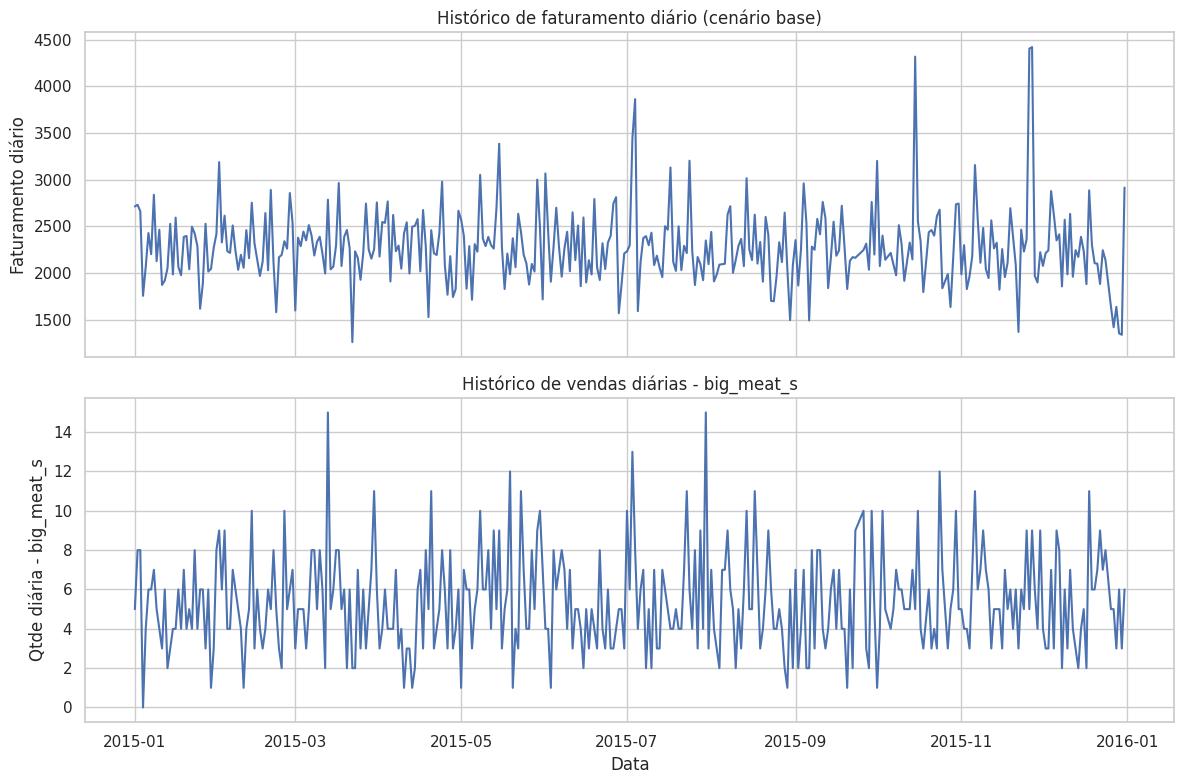

In [11]:
## Passo 04 - Séries históricas base para o modelo de promoção

# ---------------------------------------------
# 4.1 - Faturamento diário (cenário base, sem promoção)
# ---------------------------------------------

# Soma da receita por dia
daily_revenue = (
    df.groupby("date")["revenue"]
      .sum()
      .reset_index()
      .sort_values("date")
)

# Renomeia a coluna para ficar mais claro
daily_revenue.rename(columns={"revenue": "daily_revenue"}, inplace=True)

print("Faturamento diário - primeiras linhas:")
display(daily_revenue.head())

print("\nEstatísticas descritivas do faturamento diário:")
display(daily_revenue["daily_revenue"].describe())


# ---------------------------------------------
# 4.2 - Definição da pizza alvo da promoção
# ---------------------------------------------
# Aqui escolhemos qual pizza será alvo da promoção.
# Vamos começar com 'big_meat_s' (pode ser alterado depois facilmente).

# Só para conferir as variações de 'big_meat' disponíveis:
print("\nVariações de pizzas contendo 'big_meat' no ID:")
display(
    df[df["pizza_id"].str.contains("big_meat")]
      [["pizza_id", "size", "price"]]
      .drop_duplicates()
      .sort_values("pizza_id")
)

pizza_target_id = "big_meat_s"
print(f"\nPizza alvo da promoção definida como: {pizza_target_id}")


# ---------------------------------------------
# 4.3 - Quantidade diária vendida da pizza alvo
# ---------------------------------------------
# Filtra apenas a pizza alvo e soma a quantidade por dia
daily_qty_target = (
    df[df["pizza_id"] == pizza_target_id]
    .groupby("date")["quantity"]
    .sum()
    .reindex(daily_revenue["date"], fill_value=0)  # garante todas as datas
    .reset_index()
)

daily_qty_target.rename(columns={"quantity": "daily_qty_target"}, inplace=True)

print("\nQuantidade diária da pizza alvo - primeiras linhas:")
display(daily_qty_target.head())

print("\nEstatísticas descritivas da quantidade diária da pizza alvo:")
display(daily_qty_target["daily_qty_target"].describe())


# ---------------------------------------------
# 4.4 - Unindo faturamento diário e série da pizza alvo
# ---------------------------------------------
base_series = daily_revenue.merge(
    daily_qty_target,
    on="date",
    how="left"
)

# Se sobrar algum NaN por segurança, preenche com zero
base_series["daily_qty_target"] = base_series["daily_qty_target"].fillna(0)

print("\nSérie base para o modelo (faturamento diário + qtd da pizza alvo):")
display(base_series.head())


# ---------------------------------------------
# 4.5 - Visualizações rápidas (opcional mas ajuda na análise)
# ---------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Faturamento diário
axes[0].plot(base_series["date"], base_series["daily_revenue"])
axes[0].set_ylabel("Faturamento diário")
axes[0].set_title("Histórico de faturamento diário (cenário base)")

# Quantidade da pizza alvo
axes[1].plot(base_series["date"], base_series["daily_qty_target"])
axes[1].set_ylabel(f"Qtde diária - {pizza_target_id}")
axes[1].set_title(f"Histórico de vendas diárias - {pizza_target_id}")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()


Pizza alvo atual: big_meat_s
Preço atual da big_meat_s: 12.00

Parâmetros da promoção:
  Desconto        : 20%
  Uplift médio    : 30%
  Desvio padrão U : 10%
  Período (dias)  : 30
  N simulações    : 5000

Resultados da simulação (Monte Carlo):
Faturamento base médio   : 68517.75
Faturamento promo médio  : 68594.89
Delta médio (promo - base): 77.14
Desvio padrão do delta    : 31.60

Probabilidade de a promoção AUMENTAR o faturamento: 99.26%

Quantis do delta de faturamento (promo - base):
  5%  : 25.89  (cenário pessimista típico)
  50% : 77.09 (mediana)
  95% : 128.89 (cenário otimista típico)


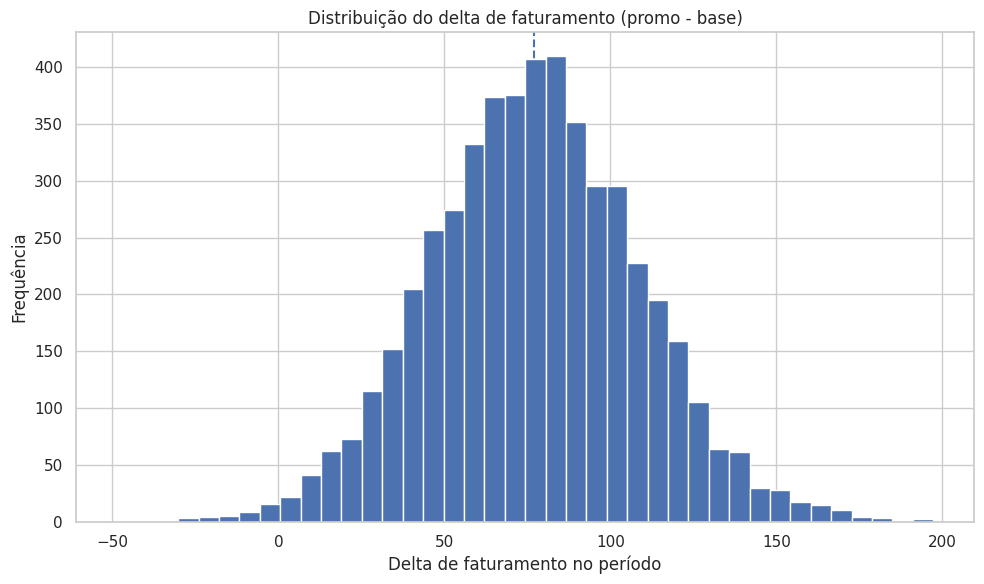

In [12]:
## Passo 05 - Simulação de Monte Carlo para avaliar a promoção

# ---------------------------------------------
# 5.1 - Parâmetros da promoção
# ---------------------------------------------

# Pizza alvo (já definida no passo anterior, mas reforçamos aqui)
print("Pizza alvo atual:", pizza_target_id)

# Pegamos o preço atual da pizza alvo a partir do df
preco_target = (
    df[df["pizza_id"] == pizza_target_id]["price"]
    .dropna()
    .iloc[0]
)

print(f"Preço atual da {pizza_target_id}: {preco_target:.2f}")

# Parâmetros da promoção
desconto = 0.20              # 20% de desconto no preço da pizza alvo
uplift_mean = 0.30           # aumento médio esperado de 30% na demanda da pizza alvo
uplift_sd   = 0.10           # desvio padrão da resposta à promoção

# Horizonte de simulação (em dias)
periodo_dias = 30            # ex.: simular um mês típico

# Número de simulações de Monte Carlo
n_simulacoes = 5000          # pode aumentar para 10000 se o notebook aguentar bem

print("\nParâmetros da promoção:")
print(f"  Desconto        : {desconto * 100:.0f}%")
print(f"  Uplift médio    : {uplift_mean * 100:.0f}%")
print(f"  Desvio padrão U : {uplift_sd * 100:.0f}%")
print(f"  Período (dias)  : {periodo_dias}")
print(f"  N simulações    : {n_simulacoes}")


# ---------------------------------------------
# 5.2 - Função que simula um período com e sem promoção
# ---------------------------------------------

def simula_promocao(
    base_series,
    preco_target,
    desconto=0.20,
    uplift_mean=0.30,
    uplift_sd=0.10,
    periodo_dias=30,
):
    """
    Simula um período de 'periodo_dias' dias, sorteando dias históricos
    e aplicando a promoção na pizza alvo.

    base_series: DataFrame com colunas:
        - 'daily_revenue'     : faturamento diário histórico total (base)
        - 'daily_qty_target'  : quantidade diária histórica da pizza alvo
    """

    # Converte para arrays NumPy para acelerar o loop
    rev_hist = base_series["daily_revenue"].values
    qty_hist = base_series["daily_qty_target"].values

    # Número de dias disponíveis no histórico
    n_dias_hist = len(base_series)

    # Faturamento total no período no cenário base e no cenário com promoção
    fat_total_base = 0.0
    fat_total_promo = 0.0

    # Preço com desconto da pizza alvo
    preco_promo = preco_target * (1 - desconto)

    for _ in range(periodo_dias):
        # 1) Sorteia um índice de dia histórico
        idx = np.random.randint(0, n_dias_hist)

        fat_dia_base = rev_hist[idx]
        qty_target_base = qty_hist[idx]

        # 2) Calcula receita das outras pizzas (sem a pizza alvo)
        #    Receita da pizza alvo no cenário base = quantidade * preço original
        receita_target_base = qty_target_base * preco_target
        receita_outras = fat_dia_base - receita_target_base

        # 3) Sorteia o fator de aumento de demanda (uplift)
        #    U ~ Normal(uplift_mean, uplift_sd), truncado em >= 0
        U = np.random.normal(uplift_mean, uplift_sd)
        if U < 0:
            U = 0.0

        # 4) Nova quantidade da pizza alvo sob promoção
        qty_target_promo = qty_target_base * (1 + U)

        # 5) Nova receita da pizza alvo com preço promocional
        receita_target_promo = qty_target_promo * preco_promo

        # 6) Receita total do dia com promoção
        fat_dia_promo = receita_outras + receita_target_promo

        # 7) Acumula nos totais
        fat_total_base += fat_dia_base
        fat_total_promo += fat_dia_promo

    return fat_total_base, fat_total_promo


# ---------------------------------------------
# 5.3 - Rodando várias simulações de Monte Carlo
# ---------------------------------------------

resultados_base = []
resultados_promo = []

for i in range(n_simulacoes):
    fat_base, fat_promo = simula_promocao(
        base_series=base_series,
        preco_target=preco_target,
        desconto=desconto,
        uplift_mean=uplift_mean,
        uplift_sd=uplift_sd,
        periodo_dias=periodo_dias,
    )
    resultados_base.append(fat_base)
    resultados_promo.append(fat_promo)

resultados_base = np.array(resultados_base)
resultados_promo = np.array(resultados_promo)

# Diferença de faturamento entre os cenários
delta_fat = resultados_promo - resultados_base


# ---------------------------------------------
# 5.4 - Estatísticas do resultado da promoção
# ---------------------------------------------

print("\nResultados da simulação (Monte Carlo):")
print(f"Faturamento base médio   : {resultados_base.mean():.2f}")
print(f"Faturamento promo médio  : {resultados_promo.mean():.2f}")
print(f"Delta médio (promo - base): {delta_fat.mean():.2f}")
print(f"Desvio padrão do delta    : {delta_fat.std():.2f}")

# Probabilidade de a promoção aumentar o faturamento
prob_melhora = (delta_fat > 0).mean()
print(f"\nProbabilidade de a promoção AUMENTAR o faturamento: {prob_melhora*100:.2f}%")

# Alguns quantis do delta (cenários pessimista, mediano, otimista)
q5, q50, q95 = np.percentile(delta_fat, [5, 50, 95])
print("\nQuantis do delta de faturamento (promo - base):")
print(f"  5%  : {q5:.2f}  (cenário pessimista típico)")
print(f"  50% : {q50:.2f} (mediana)")
print(f"  95% : {q95:.2f} (cenário otimista típico)")


# ---------------------------------------------
# 5.5 - Visualização da distribuição do delta
# ---------------------------------------------
plt.hist(delta_fat, bins=40)
plt.axvline(delta_fat.mean(), linestyle="--")
plt.title("Distribuição do delta de faturamento (promo - base)")
plt.xlabel("Delta de faturamento no período")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


In [ ]:
## Passo 06 - Análise de sensibilidade (desconto x aumento de demanda)

# ---------------------------------------------
# 6.1 - Definição dos cenários a serem testados
# ---------------------------------------------
# Diferentes níveis de desconto e de uplift médio
lista_descontos = [0.10, 0.20, 0.30]     # 10%, 20%, 30% de desconto
lista_uplift_mean = [0.10, 0.30, 0.50]   # aumento médio de 10%, 30%, 50%
uplift_sd = 0.10                         # mantemos o mesmo desvio padrão
periodo_dias = 30                        # mesmo horizonte de 30 dias
n_simulacoes_sens = 2000                 # menos simulações pra rodar mais rápido por cenário

resultados_cenarios = []  # vamos guardar os resultados aqui


# ---------------------------------------------
# 6.2 - Loop sobre os cenários de (desconto, uplift)
# ---------------------------------------------
for desc in lista_descontos:
    for up_mean in lista_uplift_mean:
        resultados_base = []
        resultados_promo = []

        for _ in range(n_simulacoes_sens):
            fat_base, fat_promo = simula_promocao(
                base_series=base_series,
                preco_target=preco_target,
                desconto=desc,
                uplift_mean=up_mean,
                uplift_sd=uplift_sd,
                periodo_dias=periodo_dias,
            )
            resultados_base.append(fat_base)
            resultados_promo.append(fat_promo)

        resultados_base = np.array(resultados_base)
        resultados_promo = np.array(resultados_promo)
        delta_fat = resultados_promo - resultados_base

        # Métricas do cenário
        fat_base_medio = resultados_base.mean()
        fat_promo_medio = resultados_promo.mean()
        delta_medio = delta_fat.mean()
        prob_melhora = (delta_fat > 0).mean()
        q5, q50, q95 = np.percentile(delta_fat, [5, 50, 95])

        resultados_cenarios.append({
            "desconto": desc,
            "uplift_mean": up_mean,
            "uplift_sd": uplift_sd,
            "periodo_dias": periodo_dias,
            "n_simulacoes": n_simulacoes_sens,
            "fat_base_medio": fat_base_medio,
            "fat_promo_medio": fat_promo_medio,
            "delta_medio": delta_medio,
            "prob_melhora": prob_melhora,
            "delta_q5": q5,
            "delta_q50": q50,
            "delta_q95": q95,
        })

# Converte para DataFrame para facilitar análise/tabulação
df_cenarios = pd.DataFrame(resultados_cenarios)

print("Resumo dos cenários de promoção (desconto x uplift):")
display(df_cenarios)
